H3. Агрегация выплат по неделям и обучение рекрентной нейронной сети повысист точность предсказания за счет анализа скрытых закономерностей

1. Loading and preparing data...

2. Aggregating data by week...

5. Training LSTM model...
Epoch 1/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - loss: 0.7678 - val_loss: 0.5170 - learning_rate: 0.0010
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.4853 - val_loss: 0.2217 - learning_rate: 0.0010
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1857 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0166 - val_loss: 0.1022 - learning_rate: 0.0010
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0966 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0187 - val_loss: 0.0075 - learning_rate: 0.0010
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0201 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0375 - val_loss: 0.0108 - learning_rate: 0.0010
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52m

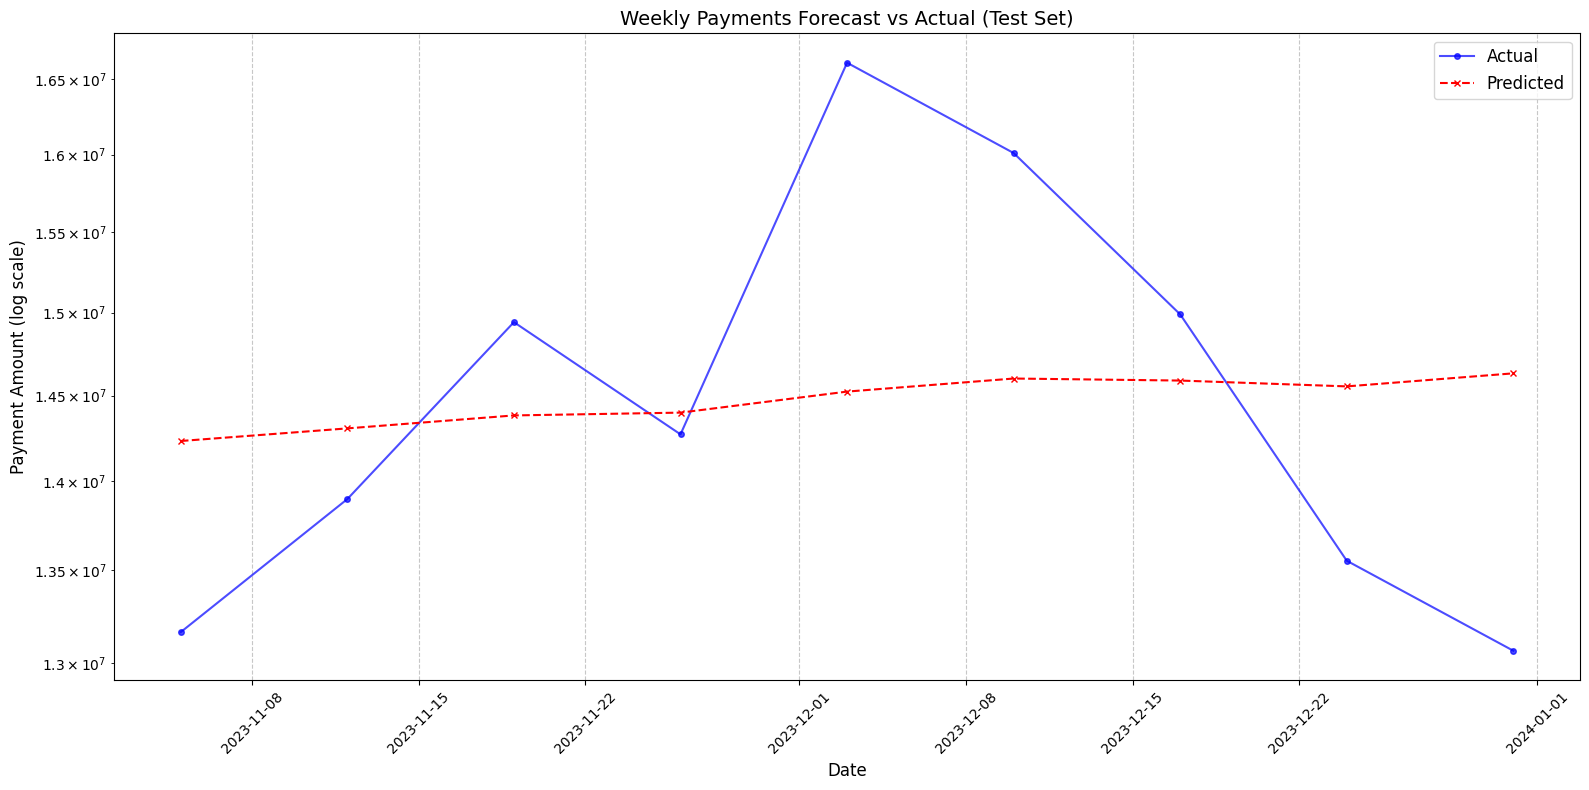


Test Metrics:
MAE: 958402.67
RMSE: 1135179.62
MAPE: 6.57%

9. Generating 1-year (52-week) forecast...
Generated forecast for week 12/52
Generated forecast for week 24/52
Generated forecast for week 36/52
Generated forecast for week 48/52


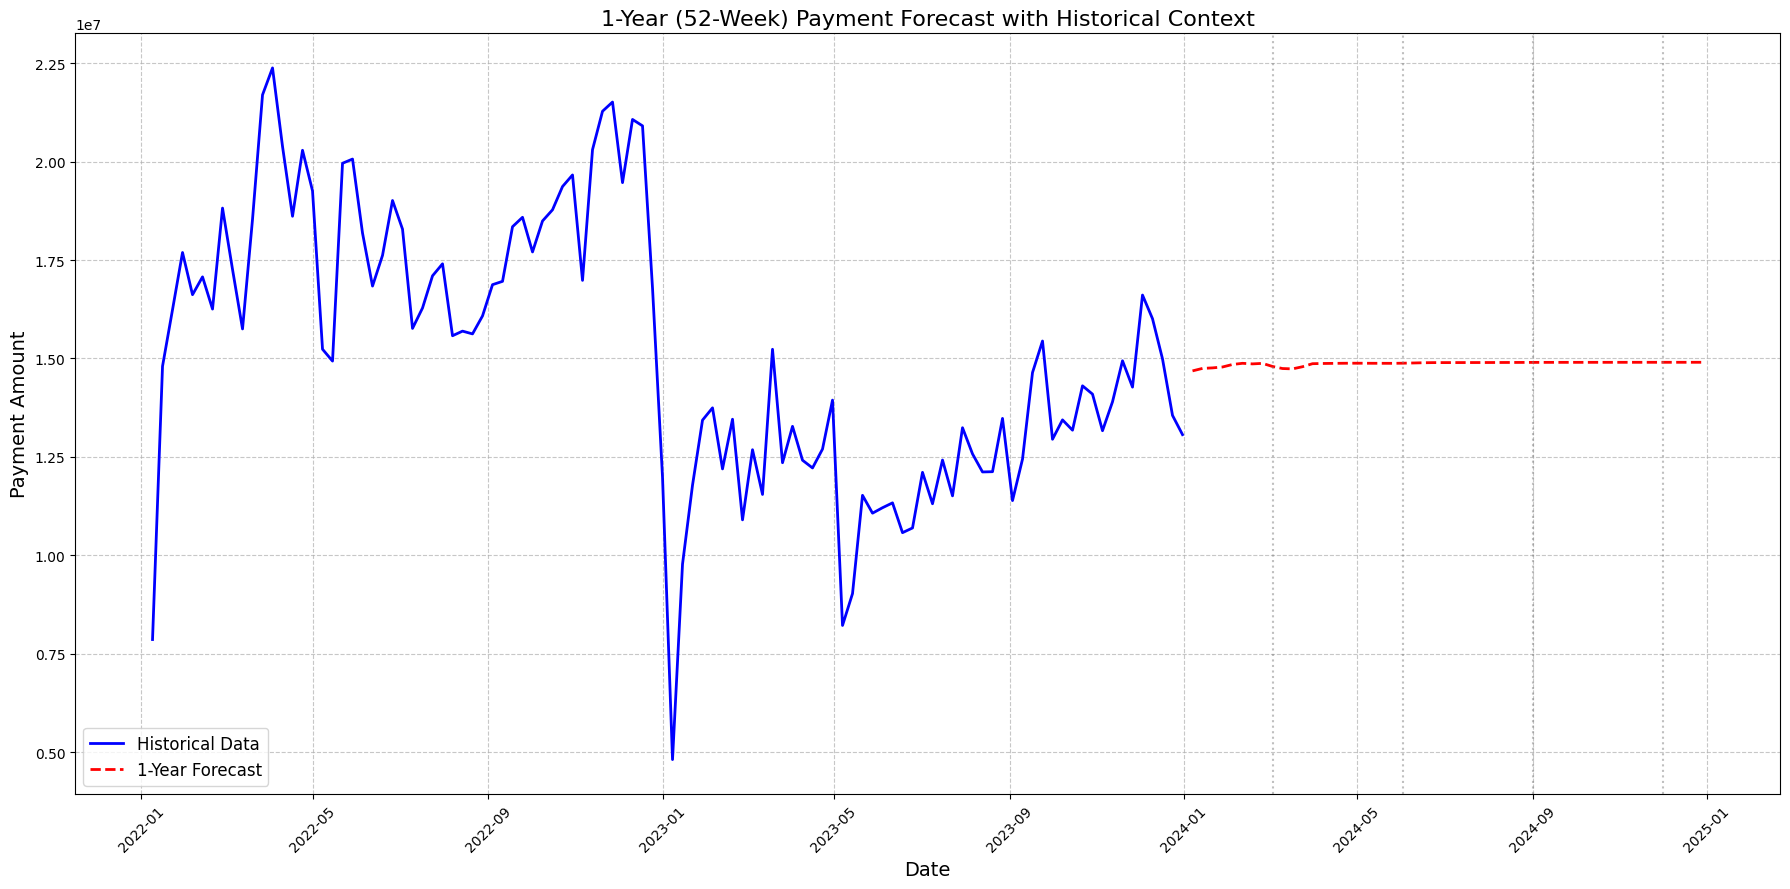


Quarterly Forecast Summary:
                      sum        mean           std
year quarter                                       
2024 Q1       192371536.0  14797810.0  62896.919713
     Q2       193459552.0  14881504.0   7387.923782
     Q3       193681824.0  14898602.0   2145.356207
     Q4       193729776.0  14902290.0    431.795951

Detailed 52-week forecast saved to 'lstm_52week_forecast.csv'


In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Load and prepare data
print("1. Loading and preparing data...")
data = pd.read_csv("CupIT_Sber_data.csv", delimiter=";")

data['service_amount_net'] = pd.to_numeric(data['service_amount_net'], errors='coerce')
data['service_date'] = pd.to_datetime(data['service_date'])
data = data.dropna(subset=['service_date', 'service_amount_net'])

# 2. Aggregate by WEEK and apply log transform
print("\n2. Aggregating data by week...")
weekly_data = data.resample('W', on='service_date')['service_amount_net'].sum().to_frame('total_payments')
weekly_data = weekly_data[weekly_data['total_payments'] > 0]
weekly_data['log_payments'] = np.log(weekly_data['total_payments'])

# 3. Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
weekly_data['scaled_payments'] = scaler.fit_transform(weekly_data[['log_payments']])

# 4. Prepare data for LSTM
def create_sequences(data, seq_length=12):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

# Using 12 weeks (about 3 months) as sequence length
seq_length = 12
train_size = int(len(weekly_data) * 0.8)
train_data = weekly_data.iloc[:train_size]['scaled_payments'].values
test_data = weekly_data.iloc[train_size:]['scaled_payments'].values

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# 5. Build and train LSTM model (enhanced for longer forecasts)
print("\n5. Training LSTM model...")
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Add early stopping and learning rate reduction
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# 6. Make predictions
print("\n6. Making predictions...")
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Plot results
plt.figure(figsize=(16, 8))
plt.plot(weekly_data.index[train_size+seq_length:], np.exp(actual), 
         label='Actual', color='blue', marker='o', markersize=4, alpha=0.7)
plt.plot(weekly_data.index[train_size+seq_length:], np.exp(predictions), 
         label='Predicted', color='red', linestyle='--', marker='x', markersize=4)
plt.title('Weekly Payments Forecast vs Actual (Test Set)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Payment Amount (log scale)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.yscale('log')  # Using log scale for better visualization
plt.tight_layout()
plt.show()

# 8. Calculate metrics
mae = mean_absolute_error(np.exp(actual), np.exp(predictions))
rmse = np.sqrt(mean_squared_error(np.exp(actual), np.exp(predictions)))
mape = np.mean(np.abs((np.exp(actual) - np.exp(predictions)) / np.exp(actual))) * 100

print("\nTest Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# 9. Future forecast - 1 year (52 weeks)
print("\n9. Generating 1-year (52-week) forecast...")
future_steps = 52
future_predictions = []
current_input = test_data[-seq_length:].tolist()

for i in range(future_steps):
    input_seq = np.array(current_input[-seq_length:]).reshape(1, seq_length, 1)
    next_pred = model.predict(input_seq, verbose=0)[0, 0]
    future_predictions.append(next_pred)
    current_input.append(next_pred)
    if (i+1) % 12 == 0:  # Print progress every 12 weeks
        print(f"Generated forecast for week {i+1}/{future_steps}")

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 10. Plot historical data with 1-year forecast
plt.figure(figsize=(18, 9))

# Plot last 2 years of historical data for context
historical_to_show = weekly_data.iloc[-104:] if len(weekly_data) > 104 else weekly_data
plt.plot(historical_to_show.index, np.exp(historical_to_show['log_payments']), 
         label='Historical Data', color='blue', linewidth=2)

# Plot forecast
forecast_dates = pd.date_range(start=weekly_data.index[-1], periods=future_steps+1, freq='W')[1:]
plt.plot(forecast_dates, np.exp(future_predictions), 
         label='1-Year Forecast', color='red', linewidth=2, linestyle='--')

# Mark quarters
quarter_dates = forecast_dates[(forecast_dates.month % 3 == 0) & (forecast_dates.day < 7)]
for qdate in quarter_dates:
    plt.axvline(x=qdate, color='gray', linestyle=':', alpha=0.5)

plt.title('1-Year (52-Week) Payment Forecast with Historical Context', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Payment Amount', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 11. Save detailed forecast
forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'forecast_amount': np.exp(future_predictions).flatten(),
    'log_forecast': future_predictions.flatten()
})

# Add month and quarter information
forecast_df['month'] = forecast_df['date'].dt.month_name()
forecast_df['quarter'] = 'Q' + forecast_df['date'].dt.quarter.astype(str)
forecast_df['year'] = forecast_df['date'].dt.year

# Calculate quarterly aggregates
quarterly_forecast = forecast_df.groupby(['year', 'quarter'])['forecast_amount'].agg(['sum', 'mean', 'std'])
print("\nQuarterly Forecast Summary:")
print(quarterly_forecast)

forecast_df.to_csv('lstm_52week_forecast.csv', index=False)
print("\nDetailed 52-week forecast saved to 'lstm_52week_forecast.csv'")

**Вывод:** Гипотеза не оправдалась, сглаживание характерное для данной архитектуры не позволяет эффективно учитывать сезонность и тренды на временном промежутке следующего года